#### iLQR for point mass example

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from ocp import *
from costs import *
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4, suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Steps:

#### 1. Define the dynamical system (e.g., double integrator, 2d robot, n-d manipulator, etc.)
#### 2. Define the cost functions
#### 3. Construct the ILQR problem
#### 4. Solve

#### Create point mass system with dimension 2 (double integrator)

In [18]:
dt = 0.05  #duration of 1 time step
T = 100    #total number of time steps
Dx, Du = 4, 2 #dimensions of x and u

#Define the matrix A and B to define a double integrator
A = np.eye(Dx)
A[:2,2:] = np.eye(2)*dt
B = np.zeros((Dx, Du))
B[2:, :] = np.eye(Du)

sys = LinearSystem(A, B)

#### Set initial state and control trajectory

In [19]:
x0 = np.zeros(Dx)
x0[3] = 1
sys.set_init_state(x0)

#set initial control to be all zeros
us = np.zeros((T+1,sys.Du))
_ = sys.compute_matrices(x0, us[0])
xs = sys.rollout(us[:-1])

#### Plot initial trajectory

#### Set the regularization cost coefficients Q and R 

In [20]:
Q = np.eye(sys.Dx)*0.  #coefficient for running cost
Qf = np.eye(sys.Dx)*1  #coefficient for terminal cost
R = np.eye(sys.Du)*.1  #control coefficient
mu = 1e-6              #regularization coefficient

#### Set target

In [21]:
x_target = np.array([2, 2, 0,0])

### iLQR using cost model

#### Define the cost

In [22]:
#The costs consist of: a) state tracking (Q), b) control regularization (R)
#Running cost is for the time 0 <= t < T, while terminal cost is for the time t = T
costs = []
for i in range(T):
    runningStateCost = CostModelQuadratic(sys, Q, x_ref = x_target)
    runningControlCost = CostModelQuadratic(sys, None, R)
    runningCost = CostModelSum(sys, [runningStateCost, runningControlCost])
    costs += [runningCost]
    
terminalStateCost = CostModelQuadratic(sys,Qf, x_ref = x_target)
terminalControlCost = CostModelQuadratic(sys, None,R)
terminalCost = CostModelSum(sys, [terminalStateCost, terminalControlCost])

costs += [terminalCost]

#### Construct ILQR

In [23]:
ilqr_cost = ILQR(sys, mu)
ilqr_cost.set_init_state(x0)
ilqr_cost.set_timestep(T)
ilqr_cost.set_cost(costs)
ilqr_cost.set_state(xs, us) #set initial guess

#### Solve and Plot

In [24]:
n_iter = 10
ilqr_cost.solve(n_iter, method='batch')
xs_batch, us_batch = ilqr_cost.xs, ilqr_cost.us

clear_output()

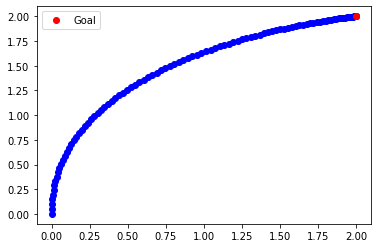

In [25]:
plt.plot(xs_batch[:,0], xs_batch[:,1], 'b-o')
plt.plot(x_target[0], x_target[1], 'or', label='Goal')
plt.legend()
plt.show()